In [ ]:
import tensorflow as tf 
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
'''
@author : wangkechn
https://github.com/wangkechn
'''

images/cat.jpg


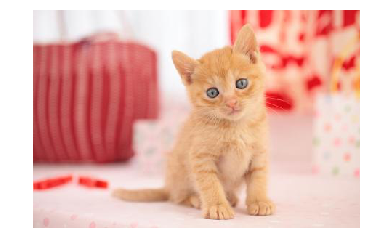

 Egyptian cat (scroe = 0.60190)
 tiger cat (scroe = 0.09699)
 crib, cot (scroe = 0.03717)
 tabby, tabby cat (scroe = 0.03121)
 quilt, comforter, comfort, puff (scroe = 0.01767)



In [2]:
class NodeLookup(object):
    def __init__(self):
        label_lookup_path = 'inception_model/imagenet_2012_challenge_label_map_proto.pbtxt' #保存目标类别 和对应的编号字符串
        uid_lookup_path = 'inception_model/imagenet_synset_to_human_label_map.txt' #保存编号字符串n****和对应的分类名称
        #这里调用了后面定义的load方法
        self.node_lookup = self.load(label_lookup_path,uid_lookup_path)
    
    #整个得到的是分类编号1-1000 对应 类别名称的 字典
    def load(self,label_lookup_path,uid_lookup_path):
        #加载分类字符串n*********对应分类名称的文件
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        
        #得到一个uid 对应 分类名称的字典
        uid_to_human = {}
        #一行一行都数据
        for line in proto_as_ascii_lines :
            #去掉换行符
            line = line.strip('\n')
            #按照'\t'分割
            parsed_items = line.split('\t')
            #获取分类编号
            uid = parsed_items[0]
            #获取分类名称
            human_string = parsed_items[1]
            #保存编号字符串n*******与分类编号1-1000的文件
            uid_to_human[uid] = human_string
            
        
        #加载分类字符串n******对应饭分类编号1-1000的文件
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        node_id_to_uid = {}
        #得到一个 编号字符串n*** 对应 分类编号的字典
        for line in proto_as_ascii :
            #原始数据前有两个空格
            if line.startswith('  target_class:'):
                #获取分类编号1-1000
                target_class = int(line.split(": ")[1])
            if line.startswith('  target_class_string:'):
                #获取编号字符串n*****
                target_class_string = line.split(': ')[1]
                
                #保存分类编号1-1000与编号字符串n******映射关系
                node_id_to_uid[target_class] = target_class_string[1:-2]
                
        #建立分类编号1-1000对应分类名称的映射关系
        node_id_to_name = {}
        for key, val in node_id_to_uid.items():
            #获取分类名称
            name = uid_to_human[val]
            #建立分类编号1-1000到分类名称的映射关系
            node_id_to_name[key] = name
        return  node_id_to_name
    
    #传入分类编号1-1000返回分类名称
    def id_to_string(self,node_id):
        if node_id not in self.node_lookup:
            return ''
        else :return self.node_lookup[node_id]

#创建一个图存放google训练好的模型    
with tf.gfile.FastGFile('inception_model/classify_image_graph_def.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def,name='')    
    
with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    #遍历目录
    for root, dirs, files in os.walk('images/'):
        for file in files:
            #载入图片
            image_data = tf.gfile.FastGFile(os.path.join(root,file),'rb').read()
            predictions = sess.run(softmax_tensor,{'DecodeJpeg/contents:0':image_data}) #载入图片是jpg格式
            predictions = np.squeeze(predictions)#把结果转为一维数据
    
            #打印图片路径及名称
            image_path = os.path.join(root,file)
            print(image_path)
            #显示图片
            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        
            #排序
            top_k = predictions.argsort()[-5:][::-1]
            node_lookup = NodeLookup()
            for node_id in top_k:
                #获取分类名称
                human_string = node_lookup.id_to_string(node_id)
                #获取该分类的置信度
                score = predictions[node_id]
                print(' %s (scroe = %.5f)' % (human_string,score))
            print()
    
            
            